In [1]:
!pip install dash

In [2]:
!pip install dash jupyter-dash


### Hypothèse 1 : Les personnes obèses sont plus souvent diabétiques



In [3]:
import pandas as pd
import numpy as np
# Chargement du dataset
df = pd.read_csv("data\heart_2022_clean.csv")

<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
/var/folders/2t/k0jf_rys24b897yq6hss2w200000gn/T/ipykernel_48307/1248802443.py:4: SyntaxWarning: invalid escape sequence '\h'
  df = pd.read_csv("data\heart_2022_clean.csv")
/var/folders/2t/k0jf_rys24b897yq6hss2w200000gn/T/ipykernel_48307/1248802443.py:4: SyntaxWarning: invalid escape sequence '\h'
  df = pd.read_csv("data\heart_2022_clean.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'data\\heart_2022_clean.csv'

In [ ]:
def obesity_class(bmi):
    if bmi < 18.5:
        return "Maigreur"
    elif 18.5 <= bmi < 25:
        return "Poids normal"
    elif 25 <= bmi < 30:
        return "Surpoids"
    elif 30 <= bmi < 35:
        return "Obésité modérée"
    elif 35 <= bmi < 40:
        return "Obésité sévère"
    else:
        return "Obésité morbide"

df["ObesityClass"] = df["BMI"].apply(obesity_class)


In [ ]:
def diabetes_binary(val):
    if val in ["Yes", "Yes, but only during pregnancy (female)"]:
        return 1
    elif val in ["No", "No"]:
        return 0
    else:
        return None  # Autres cas : valeurs manquantes explicites

df["HadDiabetes_nettoye"] = df["HadDiabetes"].apply(diabetes_binary)

# Supprimer les lignes inexploitables
df = df.dropna(subset=["ObesityClass", "HadDiabetes_nettoye"])


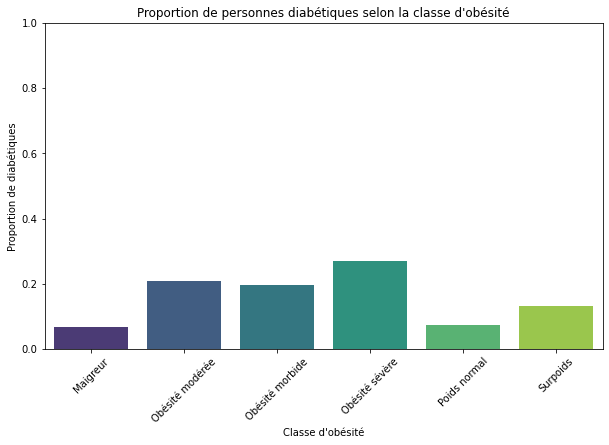

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer les moyennes (proportion de diabétiques par classe)
prop_diabete = df.groupby("ObesityClass")["HadDiabetes_nettoye"].mean().reset_index()

# Barplot
plt.figure(figsize=(10,6))
sns.barplot(data=prop_diabete, x="ObesityClass", y="HadDiabetes_nettoye", palette="viridis")
plt.title("Proportion de personnes diabétiques selon la classe d'obésité")
plt.ylabel("Proportion de diabétiques")
plt.xlabel("Classe d'obésité")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Table de contingence
contingency_table = pd.crosstab(df["ObesityClass"], df["HadDiabetes_nettoye"])

# Test du chi²
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Affichage des résultats
print(f"Chi² = {chi2:.2f}, p-value = {p:.4e}")

if p < 0.05:
    print(" Il existe une association significative entre obésité et diabète.")
else:
    print(" Aucune preuve d'association significative entre obésité et diabète.")


Chi² = 12494.61, p-value = 0.0000e+00
✅ Il existe une association significative entre obésité et diabète.


### Hypothèse 3 (clustering – mode de vie à risque)

Il existe des profils distincts de comportements à risque dans la population, que l'on peut regrouper à l’aide de KMeans sur des variables comme le tabac, l’alcool, le sommeil, l’activité physique et l’âge.
Segmenter la population pour identifier des groupes comme :

* Individus très à risque (fumeurs, buveurs, peu de sommeil, sédentaires)

* Profils “modérés” (ex-fumeurs, sommeil moyen, actifs)

* Profils sains (non-fumeurs, pas d’alcool, bon sommeil)

In [ ]:
display(df["SleepHour"].dtypes)

dtype('float64')

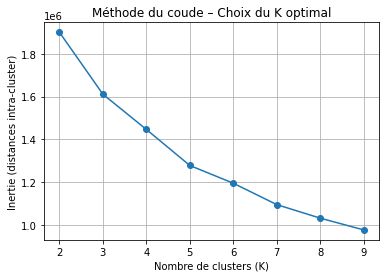

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 🎯 Sélection des variables
cols_cluster = [
    "SleepHours",
    "AlcoholDrinkers_nettoye",
    "SmokerStatus_nettoye",
    "ECigaretteUsage_nettoye",
    "PhysicalActivities_nettoye",
    "AgeCategory_nettoye"
]

df_kmeans = df[cols_cluster].dropna()

#  Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans)

# 🔍 Courbe du coude pour choisir le bon K
inertias = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode du coude – Choix du K optimal")
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie (distances intra-cluster)")
plt.grid()
plt.show()


In [ ]:
# 📈 Étape 3 – KMeans avec K=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_kmeans["Cluster"] = clusters

In [ ]:
#Colonnes originales pour lecture plus claire
cols_originales = [
    "AlcoholDrinkers",
    "SmokerStatus",
    "ECigaretteUsage",
    "PhysicalActivities",
    "AgeCategory"
]

# 📊 Moyennes par cluster (colonnes numériques)
df_moyennes = df_kmeans.groupby("Cluster")[cols_cluster].mean().round(2)

# 🧠 Colonnes originales : on récupère la valeur la plus fréquente (mode) pour chaque cluster
df_qualitatives = df.copy()
df_qualitatives["Cluster"] = df_kmeans["Cluster"]  # on ajoute les clusters au DataFrame d'origine

modes_par_cluster = df_qualitatives.groupby("Cluster")[cols_originales].agg(lambda x: x.mode().iloc[0])

# 🧷 Fusion des deux tableaux
df_interpretation = pd.concat([df_moyennes, modes_par_cluster], axis=1)

#  Affichage final
from IPython.display import display
display(df_interpretation)

,SleepHours,AlcoholDrinkers_nettoye,SmokerStatus_nettoye,ECigaretteUsage_nettoye,PhysicalActivities_nettoye,AgeCategory_nettoye,AlcoholDrinkers,SmokerStatus,ECigaretteUsage,PhysicalActivities,AgeCategory
Cluster,,,,,,,,,,,
0.0,7.03,1.00,0.05,0.93,1.0,6.39,Yes,Never smoked,Never used e-cigarettes in my entire life,Yes,Age 60 to 64
1.0,7.02,0.39,1.06,0.88,0.0,4.91,No,Never smoked,Never used e-cigarettes in my entire life,No,Age 80 or older
2.0,6.99,0.60,2.20,0.87,1.0,5.04,Yes,Former smoker,Never used e-cigarettes in my entire life,Yes,Age 65 to 69
3.0,7.05,0.00,0.04,0.92,1.0,5.76,No,Never smoked,Never used e-cigarettes in my entire life,Yes,Age 65 to 69


Cluster 0 : "Actifs sociables"
Ils sont actifs, dorment bien, mais boivent tous ➝ sociables mais pas 100 % sains

Cluster 1 : "Peu actifs, ex-fumeurs"
Ils ne font pas de sport, ont un historique de tabac, mais ne boivent pas ➝ profil à surveiller

Cluster 2 : "Profils à risque"
Boivent, fument beaucoup, souvent jeunes ➝ plusieurs comportements à risque cumulés

Cluster 3 : "Très sains"
Pas de tabac, pas d’alcool, tous font du sport ➝ comportement exemplaire

In [ ]:
#Étape 4 – Attribution des noms lisibles
cluster_labels = {
    0: "Actifs sociables",
    1: "Peu actifs, ex-fumeurs",
    2: "Profils à risque",
    3: "Profils très sains"
}
df_kmeans["ClusterLabel"] = df_kmeans["Cluster"].map(cluster_labels)

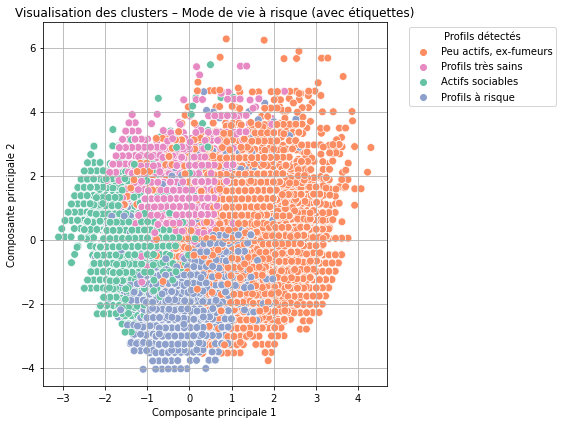

In [ ]:
#Étape 5 – Réduction de dimension pour visualisation (PCA)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_kmeans["PCA1"] = components[:, 0]
df_kmeans["PCA2"] = components[:, 1]

#  Étape 6 – Visualisation avec les noms (et palette fixe pour cohérence)
palette_fix = {
    "Actifs sociables": "#66c2a5",
    "Peu actifs, ex-fumeurs": "#fc8d62",
    "Profils à risque": "#8da0cb",
    "Profils très sains": "#e78ac3"
}

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_kmeans,
    x="PCA1",
    y="PCA2",
    hue="ClusterLabel",
    palette=palette_fix,
    s=60
)
plt.title("Visualisation des clusters – Mode de vie à risque (avec étiquettes)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Profils détectés", loc="best", bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
df["AgeCategory"].value_counts()


Age 65 to 69       47099
Age 60 to 64       44511
Age 70 to 74       43472
Age 55 to 59       36821
Age 80 or older    36251
Age 50 to 54       33644
Age 75 to 79       32518
Age 40 to 44       29942
Age 45 to 49       28531
Age 35 to 39       28526
Age 18 to 24       26941
Age 30 to 34       25807
Age 25 to 29       21990
Name: AgeCategory, dtype: int64

Le KMeans crée des groupes dominés par les profils les plus nombreux, donc logiquement :

les clusters tournent autour des personnes âgées, car elles sont très représentées,

les jeunes ne forment pas un groupe assez gros ou distinct pour générer un cluster séparé.

### Hypothese : Les personnes qui ont plus de jours de mauvaise santé mentale déclarent plus souvent des difficultés à se concentrer.

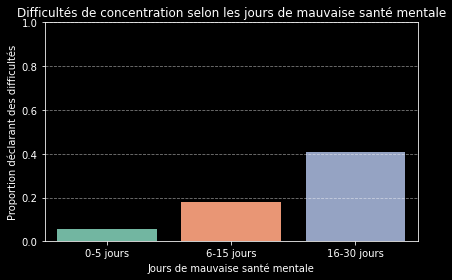

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ On suppose que tu as déjà chargé ton dataset nettoyé sous le nom : df

# ➕ Catégorisation du nombre de jours de mauvaise santé mentale
bins = [0, 5, 15, 31]
labels = ["0-5 jours", "6-15 jours", "16-30 jours"]
df["MentalHealthCategory"] = pd.cut(df["MentalHealthDays"], bins=bins, labels=labels, right=False)

# 📊 Calcul de la proportion de difficultés de concentration selon la catégorie
agg_df = df.groupby("MentalHealthCategory")["DifficultyConcentrating_nettoye"].mean().reset_index()

# 🎨 Visualisation
plt.figure(figsize=(6, 4))
sns.barplot(data=agg_df, x="MentalHealthCategory", y="DifficultyConcentrating_nettoye", palette="Set2")
plt.title("Difficultés de concentration selon les jours de mauvaise santé mentale")
plt.ylabel("Proportion déclarant des difficultés")
plt.xlabel("Jours de mauvaise santé mentale")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
